<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Sofia Jacinto</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20240598</td>
            </tr>
            <tr>
                <td style="padding: 8px;">José Cavaco</td>
                <td style="padding: 8px;"> 20240513</td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [1]:
#pip install gsgp_slim

In [2]:
# pip install slim_gsgp

In [3]:
#pip install -r requirements.txt

In [ ]:
# Imports
import numpy as np
import pandas as pd

import os
import pickle
import datetime
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from itertools import product
import gc

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import wilcoxon, friedmanchisquare

from collections import Counter
from sklearn.metrics import mean_squared_error
import scikit_posthocs as sp

import warnings
warnings.filterwarnings('ignore')

In [32]:
from slim.main_gp import gp 
#from slim.datasets.data_loader import load_ppb 
from slim.evaluators.fitness_functions import rmse 
from slim.utils.utils import train_test_split  

from slim_gsgp.datasets.data_loader import *
from slim_gsgp.main_gsgp import gsgp

In [6]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [7]:
train_color = 'blue'
test_color = 'orange'

In [8]:
#! ls

#### Helpfull Functions

In [9]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [10]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

c:\Users\catar\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\catar\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [11]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [12]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [14]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [15]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [16]:
df.set_index('wing_tag', inplace = True)

In [17]:
df.duplicated().sum()

0

#### Data Types

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [19]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [20]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [21]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [22]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

c:\Users\catar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\catar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\catar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



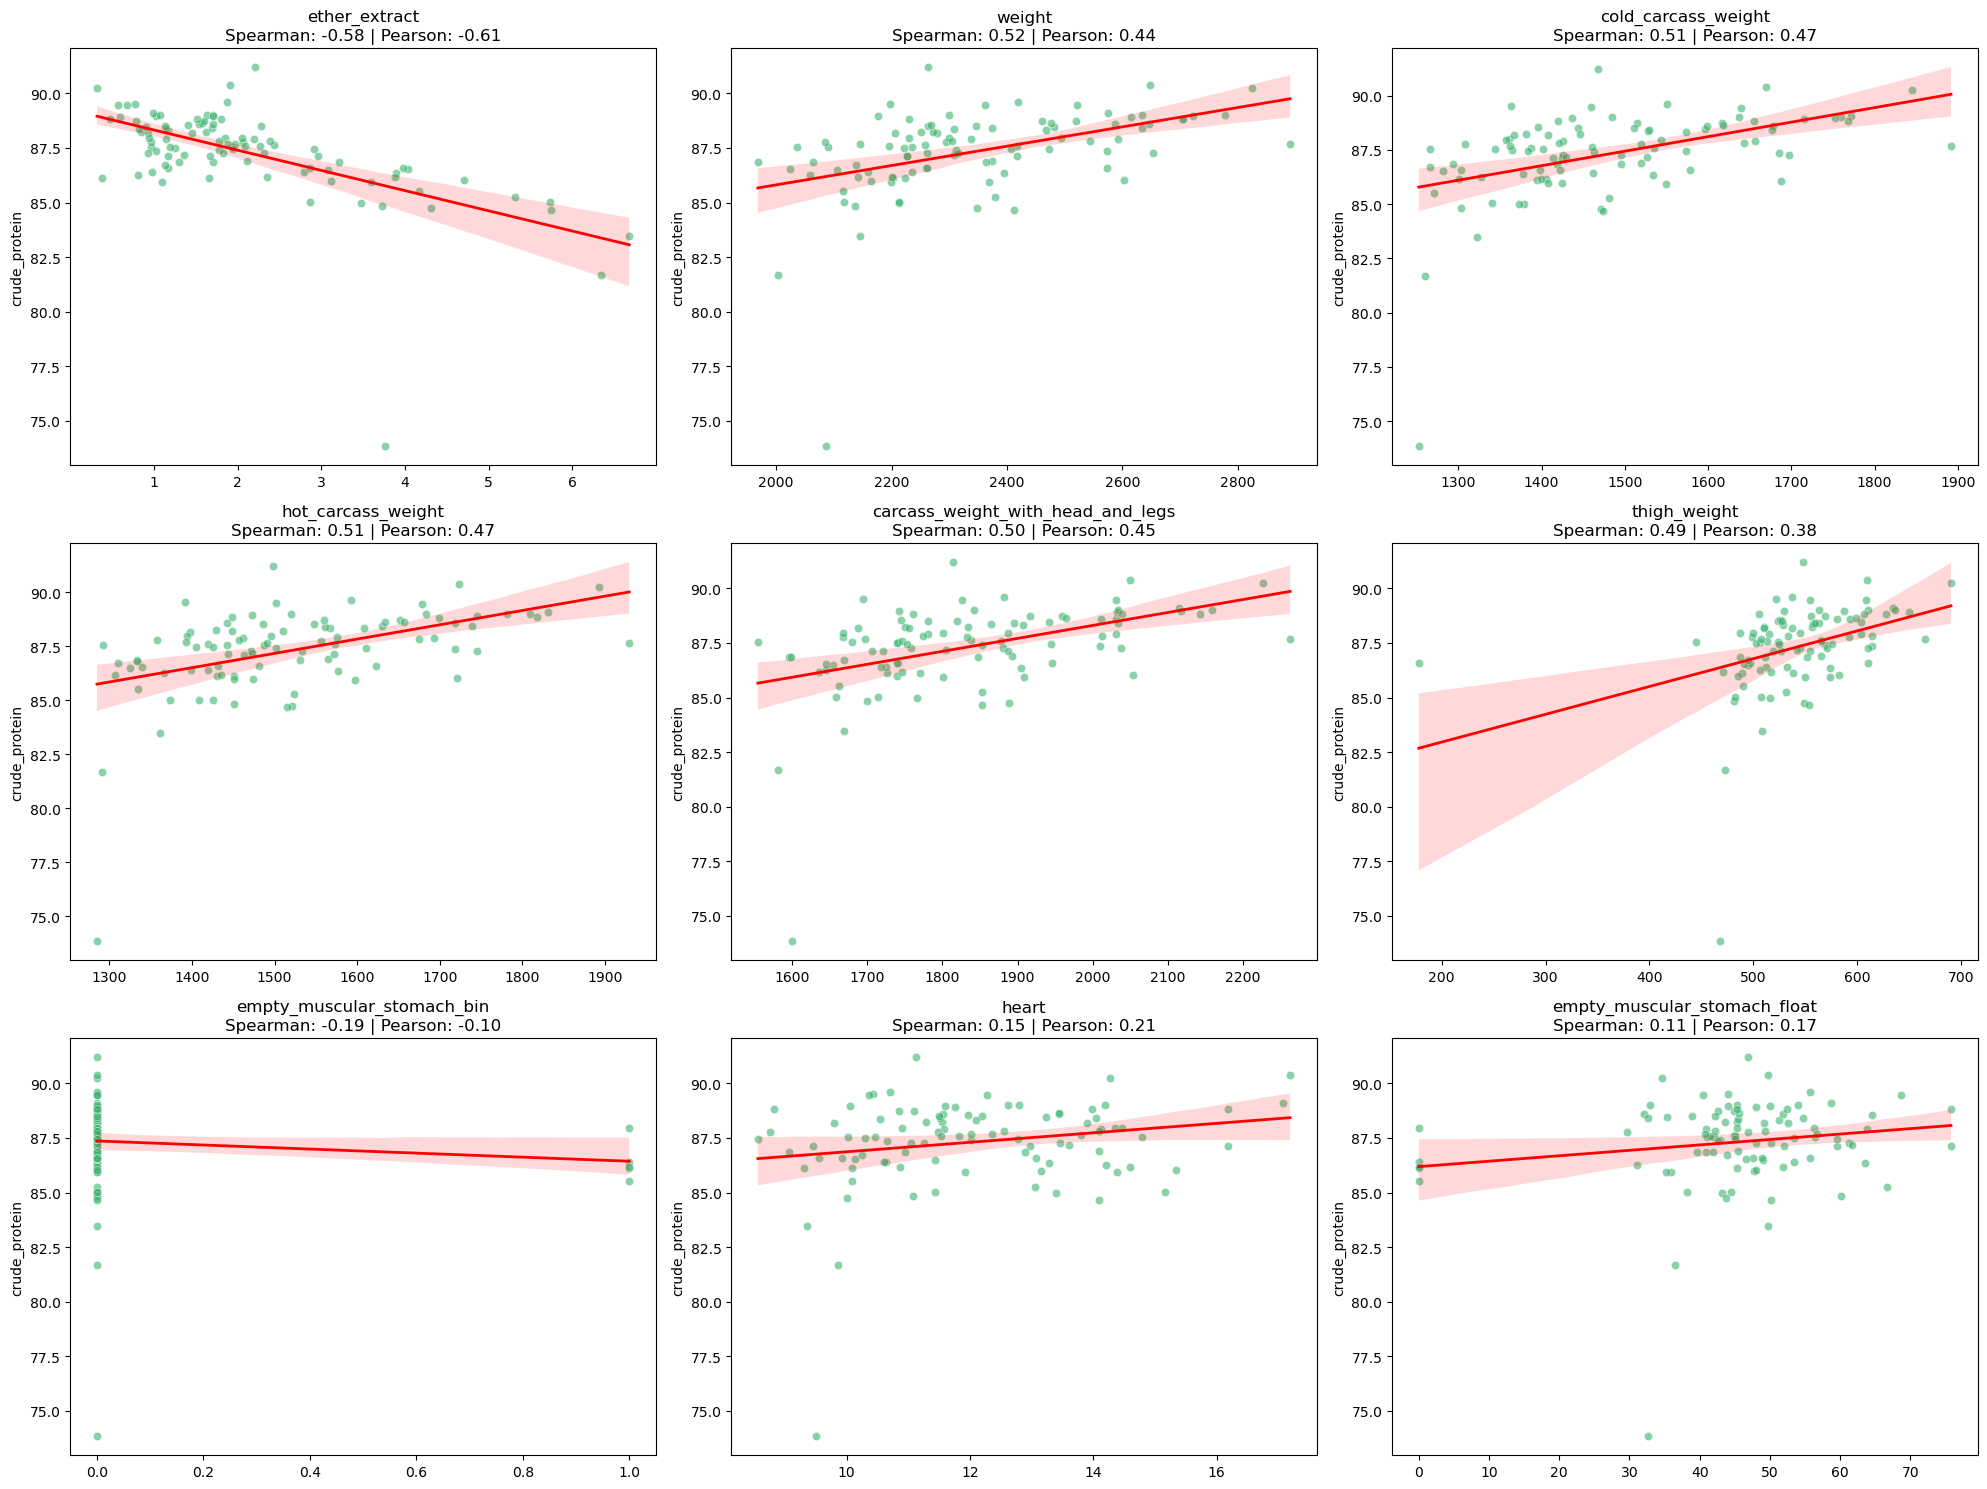

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [23]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

When  picking features for modeling, it's crucial to give a special focus on those that have the strongest correlation with the target variable, since they tend to boost predictive performance the most.

In this scenario, features like ether_extract, weight, cold_carcass_weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and thigh_weight stand out with the highest correlation to the target, making them key candidates for inclusion. 

But just because a feature has a high correlation doesn’t mean thy are useless, features that might seem less significant on their own—like heart, liver, or breast_weight—can still bring value when paired with others, especially in non-linear models or when considering interaction effects. So, while the strongest features lay a solid groundwork, it’s wise not to overlook the weaker ones too quickly without doing some additional testing in the modeling process.

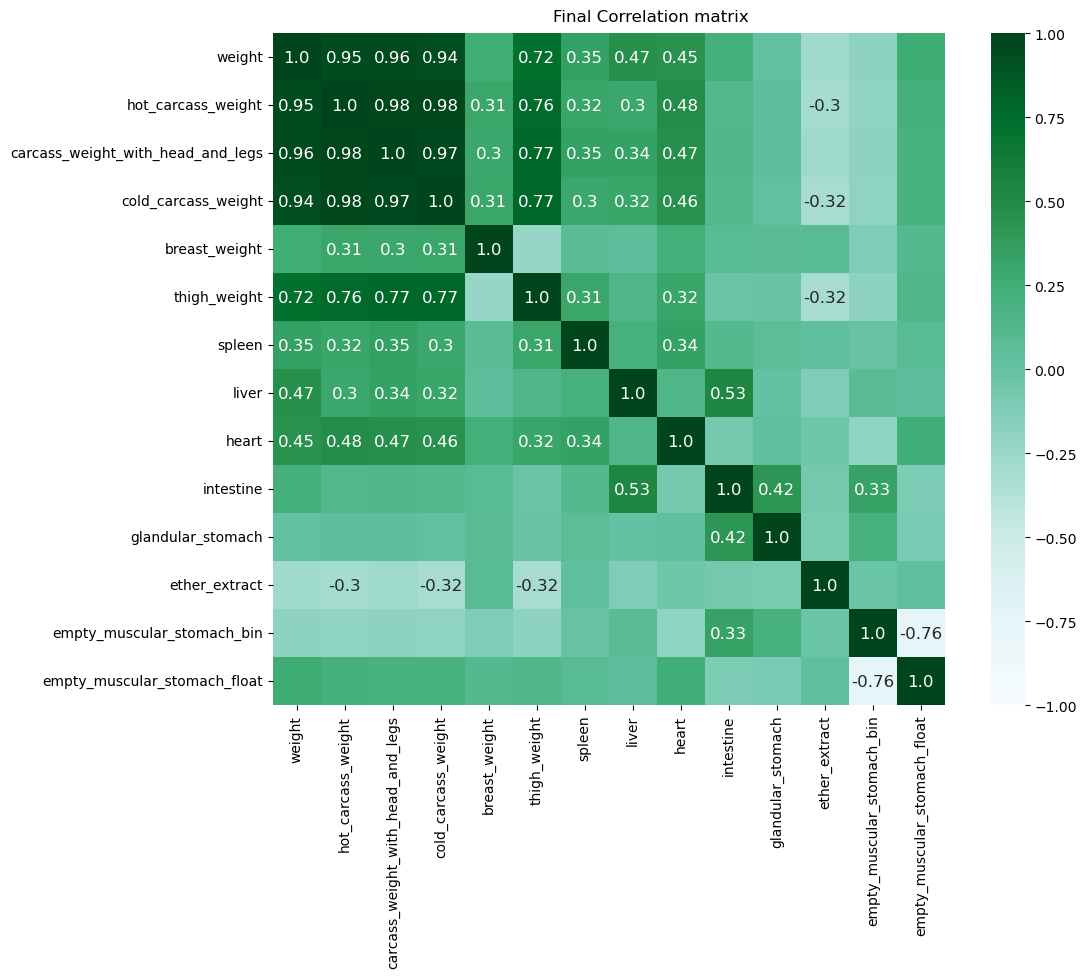

In [24]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

The correlation matrix reveals some strong linear relationships among various variables, which points to possible redundancy in the dataset:

- For example, weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and cold_carcass_weight are all highly correlated with each other, with values ranging from 0.94 to 0.98, very high. This indicates that including all four in a model or analysis could lead to multicollinearity issues.

- So, to simplify, we might want to keep just one representative variable—like hot_carcass_weight—and leave the others out.. Similarly, thigh_weight has a strong correlation with the carcass weights (up to 0.77), suggesting it could also be somewhat redundant if we already have carcass weight in the mix.



We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [25]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [26]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

`IMPORTANT:`the project description spcifically says "predict the crude protein weight using the remaining features in the dataset, excluding the animal ID." so we corrected the `empty_muscular_stomach` but we will not perform feature selection at this stage, basically we ll have this initial approach were we will test the models with all the features. If futher instructions state otherwise we will follow the analysis above.

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim)
- [5. Neural Network (NN)](#nn)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [33]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [34]:
k_outer = 5
k_inner = 3
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=seed)

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



- Dataset size: 96 samples -> GP can overfit easily on small data if trees get too big or the population too complex

In [35]:
# ===================== Nested CV Generator =====================
def nested_cv_generator(X, y, k_outer=10, k_inner=3, random_state=None):
    """ https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/"""
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
    for outer_train_idx, outer_test_idx in outer_cv.split(X):
        X_outer_train = X.iloc[outer_train_idx].reset_index(drop=True)
        y_outer_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)
        inner_splits = list(inner_cv.split(X_outer_train))

        yield {
            'X_outer_train': X_outer_train,
            'y_outer_train': y_outer_train,
            'X_test': X_test,
            'y_test': y_test,
            'inner_splits': inner_splits,
        }

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

In [30]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

> since this delivery i about GP we will keep this massive code in here to be easier to evaluate but in the final project we will do it in python file and import the function (if its ok of course) to make the notebook cleaner

In [31]:
def nested_cv_gp_slim_gsgp(
    X, y, param_grid, k_outer=5, k_inner=3, dataset_name="Chicken", gp_class=None, seed=42, alpha_sig=0.05
):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    outer_scores = []
    best_grid_models = []
    validation_results = []  # This will store detailed results for analysis
    detailed_results = []  # New: will store all fold results for all configs

    os.makedirs("./log/GP/", exist_ok=True)

    keys, values = zip(*param_grid.items())
    param_combos = [dict(zip(keys, v)) for v in product(*values)]

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer=k_outer, k_inner=k_inner, random_state=seed)):
        print(f"\n========== OUTER FOLD {fold_idx+1}/{k_outer} ==========")

        best_config = None
        best_val_score = float('inf')
        all_inner_fold_scores = []  # will be list of [k_inner] RMSEs per config

        # ============ Grid Search on Inner CV ============ #
        for config_id, flat_config in enumerate(param_combos):
            gp_config = {
                'initializer': flat_config['initializer'],
                'sspace': {
                    'p_constants': flat_config['sspace.p_constants'],
                    'max_init_depth': flat_config['sspace.max_init_depth'],
                    'max_depth': flat_config['sspace.max_depth'],
                    'tree_constants': flat_config['sspace.tree_constants'],
                },
                'pop_size': flat_config['pop_size'],
                'xo_prob': flat_config['xo_prob'],
                'generations': flat_config['generations'],
                'seed': seed
            }

            inner_fold_rmses = []

            for inner_fold_idx, (inner_train_idx, inner_val_idx) in enumerate(fold_data['inner_splits']):
                X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
                y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
                X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
                y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

                # Scaling
                x_scaler = RobustScaler()
                y_scaler = RobustScaler()
                X_train_scaled = x_scaler.fit_transform(X_train)
                X_val_scaled = x_scaler.transform(X_val)
                y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

                # Tensors
                X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

                # Model training
                model = gp_class(
                    X_train=X_train_tensor, y_train=y_train_tensor,
                    X_test=X_val_tensor, y_test=y_val_tensor,
                    dataset_name=dataset_name,
                    fitness_function='rmse',
                    minimization=True,
                    initializer=gp_config['initializer'],
                    tree_constants=gp_config['sspace']['tree_constants'],
                    tree_functions=['add', 'subtract', 'multiply', 'divide'],
                    prob_const=gp_config['sspace']['p_constants'],
                    init_depth=gp_config['sspace']['max_init_depth'],
                    max_depth=gp_config['sspace']['max_depth'],
                    pop_size=gp_config['pop_size'],
                    p_xo=gp_config['xo_prob'],
                    elitism=True,
                    n_elites=1,
                    tournament_size=2,
                    n_iter=gp_config['generations'],
                    test_elite=True,
                    log_level=0,
                    verbose=0,
                    n_jobs=1,
                    seed=gp_config['seed']
                )

                # Evaluation
                with torch.no_grad():
                    y_pred = model.predict(X_val_tensor).numpy().reshape(-1, 1)
                    y_true = y_val_tensor.numpy().reshape(-1, 1)
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    inner_fold_rmses.append(rmse)
                    
                    # Store detailed results for this fold and config
                    detailed_results.append({
                        'outer_fold': fold_idx + 1,
                        'inner_fold': inner_fold_idx + 1,
                        'config_id': config_id,
                        'config': str(flat_config),  # String representation
                        'rmse': rmse
                    })

            avg_val_rmse = np.mean(inner_fold_rmses)
            all_inner_fold_scores.append(inner_fold_rmses)

            print(f"  Config {config_id+1}/{len(param_combos)} | Inner Mean RMSE: {avg_val_rmse:.4f}")

            if avg_val_rmse < best_val_score:
                best_val_score = avg_val_rmse
                best_config = gp_config

        print(f"\n✅ Best config for outer fold {fold_idx+1}:")
        print(best_config)
        print(f"Best inner RMSE: {best_val_score:.4f}")
        best_grid_models.append(best_config)

        # Convert to DataFrame for statistical tests
        df_inner_scores = pd.DataFrame(all_inner_fold_scores).T  # shape: (k_inner, n_configs)
        validation_results.append(df_inner_scores)

        # ============ Statistical Tests ============ #
        print("\nStatistical test on inner fold scores:")
        stat, p = friedmanchisquare(*[df_inner_scores[col] for col in df_inner_scores.columns])
        print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")
        if p < alpha_sig:
            posthoc_result = sp.posthoc_nemenyi_friedman(df_inner_scores.to_numpy())
            significant_columns = posthoc_result.columns[posthoc_result.lt(0.05).any(axis=0)]
            filtered_result = posthoc_result[posthoc_result < alpha_sig]
            filtered_result = filtered_result.dropna(how='all').dropna(axis=1, how='all').fillna('-')
            print("P-values of significant differences:")
            print(filtered_result)
        else:
            print("No significant differences found between configs.")

        # ============ Boxplot ============ #
        # Convert detailed results to DataFrame for this outer fold
        df_fold_results = pd.DataFrame([r for r in detailed_results if r['outer_fold'] == fold_idx + 1])
        
        # Create labels for configurations
        config_labels = {
            i: f"Config {i+1}<br>" + "<br>".join(
                [f"{k}: {v}"[:30] for k, v in param_combos[i].items()]  # Corta cada item em 30 chars
            )
            for i in range(len(param_combos))
        }
        df_fold_results['config_label'] = df_fold_results['config_id'].map(config_labels)

        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_fold_results['config_label'],
            y=df_fold_results['rmse'],
            fillcolor='rgba(108, 140, 200, 0.3)',
            line=dict(color='rgba(108, 140, 200, 1)'),
            boxpoints='all',
            jitter=0,
            pointpos=0,
            marker=dict(color='rgba(108, 140, 200, 1)')
        ))
        fig.update_layout(
            title=f'Inner CV RMSEs - Outer Fold {fold_idx+1}',
            yaxis_title='Validation RMSE',
            width=200 * len(param_combos),
            height=400,
            plot_bgcolor='#f1f1f1',
            xaxis_tickangle=-90,
            margin=dict(l=50, r=50, t=50, b=20),
            showlegend=False
        )
        fig.show()


        # ============ Retrain on Outer Train, Evaluate on Outer Test ============ #
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_outer_train_scaled = x_scaler.fit_transform(fold_data['X_outer_train'])
        X_test_scaled = x_scaler.transform(fold_data['X_test'])
        y_outer_train_scaled = y_scaler.fit_transform(fold_data['y_outer_train'].values.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(fold_data['y_test'].values.reshape(-1, 1)).flatten()

        X_outer_train_tensor = torch.tensor(X_outer_train_scaled, dtype=torch.float32)
        y_outer_train_tensor = torch.tensor(y_outer_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_outer_train_tensor, y_train=y_outer_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name=dataset_name,
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['sspace']['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['sspace']['p_constants'],
            init_depth=best_config['sspace']['max_init_depth'],
            max_depth=best_config['sspace']['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=0,
            verbose=0,
            n_jobs=1,
            seed=best_config['seed']
        )

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            test_rmse = np.sqrt(mean_squared_error(fold_data['y_test'], y_pred_rescaled))

        print(f"\n[Outer Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)
        gc.collect()

    print(f"\n================ Final Results ================\nMean RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    df_all_results = pd.DataFrame(detailed_results)
    return np.array(outer_scores), best_grid_models, df_all_results, validation_results

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |


In [32]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.5], 
    'sspace.max_init_depth': [3, 5],
    'sspace.max_depth': [10],
    'sspace.tree_constants': [TREE_CONSTANTS],
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [30],
}

# Seeds to test
seeds = [42, 123, 456]  # You can change these to any seeds you prefer

# Store results from all seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Run the experiment
    scores, best_models, df_results, val_results = nested_cv_gp_slim_gsgp(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=gp,
        k_outer=5, k_inner=3,
        seed=seed
    )
    
    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.1030
  Config 2/32 | Inner Mean RMSE: 1.1245
  Config 3/32 | Inner Mean RMSE: 0.9767
  Config 4/32 | Inner Mean RMSE: 1.1409
  Config 5/32 | Inner Mean RMSE: 1.1371
  Config 6/32 | Inner Mean RMSE: 63.9041
  Config 7/32 | Inner Mean RMSE: 1.0270
  Config 8/32 | Inner Mean RMSE: 1.1628
  Config 9/32 | Inner Mean RMSE: 1.0993
  Config 10/32 | Inner Mean RMSE: 1.1615
  Config 11/32 | Inner Mean RMSE: 0.9713
  Config 12/32 | Inner Mean RMSE: 1.1079
  Config 13/32 | Inner Mean RMSE: 1.1945
  Config 14/32 | Inner Mean RMSE: 1.0432
  Config 15/32 | Inner Mean RMSE: 1.0483
  Config 16/32 | Inner Mean RMSE: 1.0918
  Config 17/32 | Inner Mean RMSE: 1.2279
  Config 18/32 | Inner Mean RMSE: 1.1418
  Config 19/32 | Inner Mean RMSE: 1.6617
  Config 20/32 | Inner Mean RMSE: 1.2043
  Config 21/32 | Inner Mean RMSE: 1.0635
  Config 22/32 | Inner Mean RMSE: 1.2151
  Config 23/32 | Inner Mean RMSE: 1.


[Outer Fold 1] Test RMSE: 1.7715

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.2408
  Config 2/32 | Inner Mean RMSE: 1.0892
  Config 3/32 | Inner Mean RMSE: 1.4045
  Config 4/32 | Inner Mean RMSE: 2.2868
  Config 5/32 | Inner Mean RMSE: 1.4285
  Config 6/32 | Inner Mean RMSE: 1.4285
  Config 7/32 | Inner Mean RMSE: 0.8597
  Config 8/32 | Inner Mean RMSE: 1.3618
  Config 9/32 | Inner Mean RMSE: 0.9952
  Config 10/32 | Inner Mean RMSE: 1.0301
  Config 11/32 | Inner Mean RMSE: 0.7949
  Config 12/32 | Inner Mean RMSE: 0.9319
  Config 13/32 | Inner Mean RMSE: 0.9700
  Config 14/32 | Inner Mean RMSE: 2.3206
  Config 15/32 | Inner Mean RMSE: 0.9682
  Config 16/32 | Inner Mean RMSE: 42.4112
  Config 17/32 | Inner Mean RMSE: 2.5762
  Config 18/32 | Inner Mean RMSE: 1.0922
  Config 19/32 | Inner Mean RMSE: 1.4898
  Config 20/32 | Inner Mean RMSE: 2.3080
  Config 21/32 | Inner Mean RMSE: 3.4641
  Config 22/32 | Inner Mean RMSE: 1.3397
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 2] Test RMSE: 1.3470

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 0.8136
  Config 2/32 | Inner Mean RMSE: 0.7738
  Config 3/32 | Inner Mean RMSE: 0.7506
  Config 4/32 | Inner Mean RMSE: 0.6557
  Config 5/32 | Inner Mean RMSE: 2.2537
  Config 6/32 | Inner Mean RMSE: 0.7417
  Config 7/32 | Inner Mean RMSE: 0.8525
  Config 8/32 | Inner Mean RMSE: 0.7255
  Config 9/32 | Inner Mean RMSE: 0.8129
  Config 10/32 | Inner Mean RMSE: 0.7264
  Config 11/32 | Inner Mean RMSE: 0.7123
  Config 12/32 | Inner Mean RMSE: 0.7371
  Config 13/32 | Inner Mean RMSE: 0.7973
  Config 14/32 | Inner Mean RMSE: 0.7441
  Config 15/32 | Inner Mean RMSE: 0.5873
  Config 16/32 | Inner Mean RMSE: 0.7370
  Config 17/32 | Inner Mean RMSE: 0.8223
  Config 18/32 | Inner Mean RMSE: 0.6914
  Config 19/32 | Inner Mean RMSE: 0.5858
  Config 20/32 | Inner Mean RMSE: 0.9343
  Config 21/32 | Inner Mean RMSE: 0.7820
  Config 22/32 | Inner Mean RMSE: 0.6308
  Config 23/32 | Inner Mean RMSE: 0


[Outer Fold 3] Test RMSE: 2.9472

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 0.9767
  Config 2/32 | Inner Mean RMSE: 0.9408
  Config 3/32 | Inner Mean RMSE: 1.3316
  Config 4/32 | Inner Mean RMSE: 1.2869
  Config 5/32 | Inner Mean RMSE: 0.9249
  Config 6/32 | Inner Mean RMSE: 11.4141
  Config 7/32 | Inner Mean RMSE: 1.9726
  Config 8/32 | Inner Mean RMSE: 0.9222
  Config 9/32 | Inner Mean RMSE: 0.9129
  Config 10/32 | Inner Mean RMSE: 1.0934
  Config 11/32 | Inner Mean RMSE: 0.8916
  Config 12/32 | Inner Mean RMSE: 0.9524
  Config 13/32 | Inner Mean RMSE: 1.0375
  Config 14/32 | Inner Mean RMSE: 1.0151
  Config 15/32 | Inner Mean RMSE: 1.6825
  Config 16/32 | Inner Mean RMSE: 1.0408
  Config 17/32 | Inner Mean RMSE: 0.8295
  Config 18/32 | Inner Mean RMSE: 0.9497
  Config 19/32 | Inner Mean RMSE: 1.7619
  Config 20/32 | Inner Mean RMSE: 1.1023
  Config 21/32 | Inner Mean RMSE: 0.9699
  Config 22/32 | Inner Mean RMSE: 1.0692
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 4] Test RMSE: 1.4551

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.5369
  Config 2/32 | Inner Mean RMSE: 1.2493
  Config 3/32 | Inner Mean RMSE: 1.1523
  Config 4/32 | Inner Mean RMSE: 1.2501
  Config 5/32 | Inner Mean RMSE: 2.7517
  Config 6/32 | Inner Mean RMSE: 1.4018
  Config 7/32 | Inner Mean RMSE: 0.9126
  Config 8/32 | Inner Mean RMSE: 0.9270
  Config 9/32 | Inner Mean RMSE: 1.1070
  Config 10/32 | Inner Mean RMSE: 1.1556
  Config 11/32 | Inner Mean RMSE: 1.0991
  Config 12/32 | Inner Mean RMSE: 1.0986
  Config 13/32 | Inner Mean RMSE: 1.1714
  Config 14/32 | Inner Mean RMSE: 1.1948
  Config 15/32 | Inner Mean RMSE: 1.5924
  Config 16/32 | Inner Mean RMSE: 1.0312
  Config 17/32 | Inner Mean RMSE: 0.9768
  Config 18/32 | Inner Mean RMSE: 1.1471
  Config 19/32 | Inner Mean RMSE: 1.0719
  Config 20/32 | Inner Mean RMSE: 1.3266
  Config 21/32 | Inner Mean RMSE: 1.7840
  Config 22/32 | Inner Mean RMSE: 1.1164
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 5] Test RMSE: 1.2561

================ Final Results ================
Mean RMSE: 1.7554 ± 0.6208

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 0.7816
  Config 2/32 | Inner Mean RMSE: 0.8224
  Config 3/32 | Inner Mean RMSE: 0.5854
  Config 4/32 | Inner Mean RMSE: 0.8536
  Config 5/32 | Inner Mean RMSE: 0.5484
  Config 6/32 | Inner Mean RMSE: 0.6176
  Config 7/32 | Inner Mean RMSE: 0.6131
  Config 8/32 | Inner Mean RMSE: 0.6558
  Config 9/32 | Inner Mean RMSE: 0.5830
  Config 10/32 | Inner Mean RMSE: 0.5744
  Config 11/32 | Inner Mean RMSE: 0.6669
  Config 12/32 | Inner Mean RMSE: 0.6025
  Config 13/32 | Inner Mean RMSE: 0.5826
  Config 14/32 | Inner Mean RMSE: 0.6297
  Config 15/32 | Inner Mean RMSE: 0.5717
  Config 16/32 | Inner Mean RMSE: 0.5792
  Config 17/32 | Inner Mean RMSE: 0.6090
  Config 18/32 | Inner Mean RMSE: 0.6238
  Config 19/32 | Inner Mean RMSE: 0.5581
  Config 20/32 | Inner Mean RMSE: 0.5733
  Config


[Outer Fold 1] Test RMSE: 3.1687

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.1267
  Config 2/32 | Inner Mean RMSE: 1.2121
  Config 3/32 | Inner Mean RMSE: 0.8698
  Config 4/32 | Inner Mean RMSE: 1.0001
  Config 5/32 | Inner Mean RMSE: 0.8368
  Config 6/32 | Inner Mean RMSE: 0.9071
  Config 7/32 | Inner Mean RMSE: 0.8396
  Config 8/32 | Inner Mean RMSE: 0.9628
  Config 9/32 | Inner Mean RMSE: 0.8258
  Config 10/32 | Inner Mean RMSE: 0.9326
  Config 11/32 | Inner Mean RMSE: 0.9660
  Config 12/32 | Inner Mean RMSE: 0.7979
  Config 13/32 | Inner Mean RMSE: 0.9655
  Config 14/32 | Inner Mean RMSE: 0.9263
  Config 15/32 | Inner Mean RMSE: 0.8157
  Config 16/32 | Inner Mean RMSE: 0.9372
  Config 17/32 | Inner Mean RMSE: 0.8782
  Config 18/32 | Inner Mean RMSE: 0.8695
  Config 19/32 | Inner Mean RMSE: 0.9556
  Config 20/32 | Inner Mean RMSE: 0.9959
  Config 21/32 | Inner Mean RMSE: 1.1181
  Config 22/32 | Inner Mean RMSE: 1.1798
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 2] Test RMSE: 1.2280

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.3484
  Config 2/32 | Inner Mean RMSE: 1.0113
  Config 3/32 | Inner Mean RMSE: 0.9478
  Config 4/32 | Inner Mean RMSE: 1.2682
  Config 5/32 | Inner Mean RMSE: 0.9924
  Config 6/32 | Inner Mean RMSE: 2.5974
  Config 7/32 | Inner Mean RMSE: 1.3553
  Config 8/32 | Inner Mean RMSE: 1.0008
  Config 9/32 | Inner Mean RMSE: 0.9820
  Config 10/32 | Inner Mean RMSE: 1.0819
  Config 11/32 | Inner Mean RMSE: 0.9301
  Config 12/32 | Inner Mean RMSE: 0.9962
  Config 13/32 | Inner Mean RMSE: 1.0006
  Config 14/32 | Inner Mean RMSE: 0.9692
  Config 15/32 | Inner Mean RMSE: 0.8989
  Config 16/32 | Inner Mean RMSE: 0.9948
  Config 17/32 | Inner Mean RMSE: 1.0395
  Config 18/32 | Inner Mean RMSE: 1.0627
  Config 19/32 | Inner Mean RMSE: 1.0583
  Config 20/32 | Inner Mean RMSE: 1.0544
  Config 21/32 | Inner Mean RMSE: 0.9269
  Config 22/32 | Inner Mean RMSE: 1.0804
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 3] Test RMSE: 1.1817

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.0768
  Config 2/32 | Inner Mean RMSE: 1.2048
  Config 3/32 | Inner Mean RMSE: 0.8790
  Config 4/32 | Inner Mean RMSE: 0.8212
  Config 5/32 | Inner Mean RMSE: 1.0141
  Config 6/32 | Inner Mean RMSE: 0.8853
  Config 7/32 | Inner Mean RMSE: 1.0801
  Config 8/32 | Inner Mean RMSE: 0.9211
  Config 9/32 | Inner Mean RMSE: 0.9466
  Config 10/32 | Inner Mean RMSE: 0.9564
  Config 11/32 | Inner Mean RMSE: 0.9700
  Config 12/32 | Inner Mean RMSE: 0.9209
  Config 13/32 | Inner Mean RMSE: 0.8728
  Config 14/32 | Inner Mean RMSE: 0.9977
  Config 15/32 | Inner Mean RMSE: 0.8608
  Config 16/32 | Inner Mean RMSE: 1.0685
  Config 17/32 | Inner Mean RMSE: 0.8288
  Config 18/32 | Inner Mean RMSE: 1.1973
  Config 19/32 | Inner Mean RMSE: 1.0408
  Config 20/32 | Inner Mean RMSE: 1.1493
  Config 21/32 | Inner Mean RMSE: 1.1252
  Config 22/32 | Inner Mean RMSE: 1.5071
  Config 23/32 | Inner Mean RMSE: 2


[Outer Fold 4] Test RMSE: 1.1023

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.3306
  Config 2/32 | Inner Mean RMSE: 1.1989
  Config 3/32 | Inner Mean RMSE: 0.9956
  Config 4/32 | Inner Mean RMSE: 0.8881
  Config 5/32 | Inner Mean RMSE: 0.9608
  Config 6/32 | Inner Mean RMSE: 0.9843
  Config 7/32 | Inner Mean RMSE: 0.9305
  Config 8/32 | Inner Mean RMSE: 0.9086
  Config 9/32 | Inner Mean RMSE: 1.0261
  Config 10/32 | Inner Mean RMSE: 1.0997
  Config 11/32 | Inner Mean RMSE: 0.8021
  Config 12/32 | Inner Mean RMSE: 0.7949
  Config 13/32 | Inner Mean RMSE: 0.9731
  Config 14/32 | Inner Mean RMSE: 1.0880
  Config 15/32 | Inner Mean RMSE: 0.9153
  Config 16/32 | Inner Mean RMSE: 1.0063
  Config 17/32 | Inner Mean RMSE: 0.9731
  Config 18/32 | Inner Mean RMSE: 20.0225
  Config 19/32 | Inner Mean RMSE: 2.2455
  Config 20/32 | Inner Mean RMSE: 1.1164
  Config 21/32 | Inner Mean RMSE: 0.9650
  Config 22/32 | Inner Mean RMSE: 2.3725
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 5] Test RMSE: 1.3215

================ Final Results ================
Mean RMSE: 1.6004 ± 0.7873

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 0.7453
  Config 2/32 | Inner Mean RMSE: 0.8814
  Config 3/32 | Inner Mean RMSE: 0.8708
  Config 4/32 | Inner Mean RMSE: 0.6314
  Config 5/32 | Inner Mean RMSE: 0.7588
  Config 6/32 | Inner Mean RMSE: 0.7764
  Config 7/32 | Inner Mean RMSE: 0.9126
  Config 8/32 | Inner Mean RMSE: 0.8129
  Config 9/32 | Inner Mean RMSE: 0.6437
  Config 10/32 | Inner Mean RMSE: 0.5827
  Config 11/32 | Inner Mean RMSE: 0.5714
  Config 12/32 | Inner Mean RMSE: 1.6877
  Config 13/32 | Inner Mean RMSE: 0.5850
  Config 14/32 | Inner Mean RMSE: 0.8901
  Config 15/32 | Inner Mean RMSE: 0.6164
  Config 16/32 | Inner Mean RMSE: 0.8897
  Config 17/32 | Inner Mean RMSE: 0.8047
  Config 18/32 | Inner Mean RMSE: 0.7035
  Config 19/32 | Inner Mean RMSE: 0.7259
  Config 20/32 | Inner Mean RMSE: 0.6739
  Config


[Outer Fold 1] Test RMSE: 3.0606

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 7.2943
  Config 2/32 | Inner Mean RMSE: 0.9997
  Config 3/32 | Inner Mean RMSE: 0.9577
  Config 4/32 | Inner Mean RMSE: 1.0730
  Config 5/32 | Inner Mean RMSE: 0.9142
  Config 6/32 | Inner Mean RMSE: 1.0341
  Config 7/32 | Inner Mean RMSE: 0.8995
  Config 8/32 | Inner Mean RMSE: 1.4908
  Config 9/32 | Inner Mean RMSE: 0.8400
  Config 10/32 | Inner Mean RMSE: 0.8989
  Config 11/32 | Inner Mean RMSE: 0.8358
  Config 12/32 | Inner Mean RMSE: 0.8521
  Config 13/32 | Inner Mean RMSE: 1.2376
  Config 14/32 | Inner Mean RMSE: 0.8919
  Config 15/32 | Inner Mean RMSE: 1.9891
  Config 16/32 | Inner Mean RMSE: 1.5459
  Config 17/32 | Inner Mean RMSE: 0.9562
  Config 18/32 | Inner Mean RMSE: 0.9480
  Config 19/32 | Inner Mean RMSE: 0.8844
  Config 20/32 | Inner Mean RMSE: 0.9230
  Config 21/32 | Inner Mean RMSE: 1.0564
  Config 22/32 | Inner Mean RMSE: 1.8358
  Config 23/32 | Inner Mean RMSE: 0


[Outer Fold 2] Test RMSE: 0.9011

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.1348
  Config 2/32 | Inner Mean RMSE: 0.8876
  Config 3/32 | Inner Mean RMSE: 0.9065
  Config 4/32 | Inner Mean RMSE: 0.9476
  Config 5/32 | Inner Mean RMSE: 0.9722
  Config 6/32 | Inner Mean RMSE: 1.0435
  Config 7/32 | Inner Mean RMSE: 0.9829
  Config 8/32 | Inner Mean RMSE: 0.9418
  Config 9/32 | Inner Mean RMSE: 0.8051
  Config 10/32 | Inner Mean RMSE: 0.7859
  Config 11/32 | Inner Mean RMSE: 0.8736
  Config 12/32 | Inner Mean RMSE: 0.8001
  Config 13/32 | Inner Mean RMSE: 1.0288
  Config 14/32 | Inner Mean RMSE: 1.0582
  Config 15/32 | Inner Mean RMSE: 0.8536
  Config 16/32 | Inner Mean RMSE: 0.9117
  Config 17/32 | Inner Mean RMSE: 0.8873
  Config 18/32 | Inner Mean RMSE: 0.9073
  Config 19/32 | Inner Mean RMSE: 1.0179
  Config 20/32 | Inner Mean RMSE: 0.9304
  Config 21/32 | Inner Mean RMSE: 0.9979
  Config 22/32 | Inner Mean RMSE: 0.8979
  Config 23/32 | Inner Mean RMSE: 0


[Outer Fold 3] Test RMSE: 1.5046

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 0.8244
  Config 2/32 | Inner Mean RMSE: 0.9251
  Config 3/32 | Inner Mean RMSE: 1.0055
  Config 4/32 | Inner Mean RMSE: 0.9363
  Config 5/32 | Inner Mean RMSE: 0.8413
  Config 6/32 | Inner Mean RMSE: 0.8608
  Config 7/32 | Inner Mean RMSE: 0.7180
  Config 8/32 | Inner Mean RMSE: 0.8010
  Config 9/32 | Inner Mean RMSE: 0.7585
  Config 10/32 | Inner Mean RMSE: 0.7443
  Config 11/32 | Inner Mean RMSE: 0.7453
  Config 12/32 | Inner Mean RMSE: 0.8428
  Config 13/32 | Inner Mean RMSE: 0.8574
  Config 14/32 | Inner Mean RMSE: 0.8715
  Config 15/32 | Inner Mean RMSE: 0.7756
  Config 16/32 | Inner Mean RMSE: 1.2322
  Config 17/32 | Inner Mean RMSE: 1.7206
  Config 18/32 | Inner Mean RMSE: 1.1705
  Config 19/32 | Inner Mean RMSE: 0.8989
  Config 20/32 | Inner Mean RMSE: 1.1650
  Config 21/32 | Inner Mean RMSE: 1.2740
  Config 22/32 | Inner Mean RMSE: 1.0795
  Config 23/32 | Inner Mean RMSE: 0


[Outer Fold 4] Test RMSE: 0.8728

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 0.8763
  Config 2/32 | Inner Mean RMSE: 0.9240
  Config 3/32 | Inner Mean RMSE: 0.8747
  Config 4/32 | Inner Mean RMSE: 1.0264
  Config 5/32 | Inner Mean RMSE: 0.8613
  Config 6/32 | Inner Mean RMSE: 0.9898
  Config 7/32 | Inner Mean RMSE: 0.9619
  Config 8/32 | Inner Mean RMSE: 1.1411
  Config 9/32 | Inner Mean RMSE: 0.8394
  Config 10/32 | Inner Mean RMSE: 0.8513
  Config 11/32 | Inner Mean RMSE: 0.7668
  Config 12/32 | Inner Mean RMSE: 0.8353
  Config 13/32 | Inner Mean RMSE: 0.9064
  Config 14/32 | Inner Mean RMSE: 0.9367
  Config 15/32 | Inner Mean RMSE: 0.9226
  Config 16/32 | Inner Mean RMSE: 0.9923
  Config 17/32 | Inner Mean RMSE: 1.0706
  Config 18/32 | Inner Mean RMSE: 1.0118
  Config 19/32 | Inner Mean RMSE: 0.8875
  Config 20/32 | Inner Mean RMSE: 0.9843
  Config 21/32 | Inner Mean RMSE: 0.9191
  Config 22/32 | Inner Mean RMSE: 0.9964
  Config 23/32 | Inner Mean RMSE: 0


[Outer Fold 5] Test RMSE: 0.9146

================ Final Results ================
Mean RMSE: 1.4507 ± 0.8388


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [33]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
                        for k, v in most_common_config_hash)
        
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")



=== Final Results ===
Mean RMSE across seeds: 1.6022 ± 0.4017

Best configuration found in most runs:
  generations: 30
  initializer: rhh
  pop_size: 50
  seed: 456
  sspace:
    max_depth: 10
    max_init_depth: 5
    p_constants: 0.5
    tree_constants: (0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0)
  xo_prob: 0.9


> Running GP with Best Config  

In [34]:
# ========== Config from Best Run ==========
best_config = {
    'initializer': 'rhh',
    'prob_const': 0.5,
    'init_depth': 5,
    'max_depth': 10,
    'tree_constants': [
        0.6394267984578837, 0.025010755222666936, 0.27502931836911926,
        0.22321073814882275, 0.7364712141640124, 0.6766994874229113,
        0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0
    ],
    'pop_size': 50,
    'xo_prob': 0.9,
    'generations': 30,
    'seed': 456
}

In [35]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            max_depth=best_config['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=2,
            log_path=f"./log/GP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed']
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [36]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gp, k_outer=5)


=== Outer Fold 1/5 ===


Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   1.0345208644866943  |   1.1248681545257568     |   0.0655364990234375   |      5           |
|     🐓 Chicken 🐓         |       1      |   0.9431015849113464  |   0.9419897198677063     |   0.03601574897766113  |      5           |
|     🐓 Chicken 🐓         |       2      |   0.9431015849113464  |   0.9419897198677063     |   0.015018463134765625 |      5           |
|     🐓 Chicken 🐓         |       3      |   0.9431015849113464  |   0.9419897198677063     |   0.04829907417297363  |      5           |
|     🐓 Chicken 🐓

In [37]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    if hasattr(model, 'print_tree_representation'):
        model.print_tree_representation()  # Direct print if available
    else:
        # Fallback for unsupported methods
        print("No tree printing method found. Try manual inspection:")
        print("Model attributes:", [attr for attr in dir(model) if not attr.startswith('_')])


=== Tree Representation (Fold 1) ===
multiply(
  multiply(
    constant__1.0
    x12
  )
  add(
    constant_0.27502931836911926
    constant_0.27502931836911926
  )
)

=== Tree Representation (Fold 2) ===
multiply(
  multiply(
    constant__1.0
    x12
  )
  constant_0.6394267984578837
)

=== Tree Representation (Fold 3) ===
multiply(
  subtract(
    constant_0.6766994874229113
    multiply(
      constant_0.7364712141640124
      add(
        multiply(
          constant_0.7364712141640124
          multiply(
            constant_0.7364712141640124
            add(
              multiply(
                constant_0.7364712141640124
                constant_0.08693883262941615
              )
              multiply(
                constant_0.7364712141640124
                constant_0.08693883262941615
              )
            )
          )
        )
        multiply(
          constant_0.7364712141640124
          multiply(
            constant_0.7364712141640124
            add

In [38]:
LOG_DIR = "log/GP/"
folds = [pd.read_csv(f"{LOG_DIR}fold_{i}.csv", header=None) for i in range(1, 6)]

In [39]:
COLUMN_NAMES = [
    "Algorithm",      # 0
    "Instance_ID",    # 1
    "Dataset",        # 2
    "Seed",           # 3
    "Generation",     # 4
    "Fitness",        # 5 (Train RMSE)
    "Running_time",   # 6
    "Population_nodes", # 7
    "Test_fitness",   # 8 (Test RMSE)
    "Elite_nodes",    # 9 (Tree size)
    "Niche_entropy",  # 10
    "SD_pop_fit",     # 11 (Fitness diversity)
    "Log_level"       # 12
]

# Load all folds with column names
folds = []
for i in range(1, 6):
    df = pd.read_csv(f"log/GP/fold_{i}.csv", header=None)
    df.columns = COLUMN_NAMES  # Assign column names
    folds.append(df)

In [40]:
folds[0].head()
#folds[0]['Niche_entropy'].unique() --- always 0

,Algorithm,Instance_ID,Dataset,Seed,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit,Log_level
0,StandardGP,6e3bc999-3377-11f0-bf10-18cc188d0b75,🐓 Chicken 🐓,456,0,1.034521,0.065536,432.0,1.124868,5,0.0,13.664401,2
1,StandardGP,6e3bc999-3377-11f0-bf10-18cc188d0b75,🐓 Chicken 🐓,456,1,0.943102,0.036016,314.0,0.941990,5,0.0,1.306636,2
2,StandardGP,6e3bc999-3377-11f0-bf10-18cc188d0b75,🐓 Chicken 🐓,456,2,0.943102,0.015018,286.0,0.941990,5,0.0,2.338794,2
3,StandardGP,6e3bc999-3377-11f0-bf10-18cc188d0b75,🐓 Chicken 🐓,456,3,0.943102,0.048299,272.0,0.941990,5,0.0,62.388210,2
4,StandardGP,6e3bc999-3377-11f0-bf10-18cc188d0b75,🐓 Chicken 🐓,456,4,0.943102,0.027217,256.0,0.941990,5,0.0,5.142430,2


In [41]:
NUMERIC_COLS = ["Generation", "Fitness", "Running_time", "Population_nodes", 
                "Test_fitness", "Elite_nodes", "Niche_entropy", "SD_pop_fit"]
numeric_folds = [df[NUMERIC_COLS] for df in folds]

In [42]:
numeric_folds[0].head()

,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit
0,0,1.034521,0.065536,432.0,1.124868,5,0.0,13.664401
1,1,0.943102,0.036016,314.0,0.941990,5,0.0,1.306636
2,2,0.943102,0.015018,286.0,0.941990,5,0.0,2.338794
3,3,0.943102,0.048299,272.0,0.941990,5,0.0,62.388210
4,4,0.943102,0.027217,256.0,0.941990,5,0.0,5.142430


In [43]:
all_data = np.stack([df.values for df in numeric_folds])

#  mean and std across folds
mean = np.mean(all_data, axis=0)  
std = np.std(all_data, axis=0)
mean_df = pd.DataFrame(mean, columns=NUMERIC_COLS)
std_df = pd.DataFrame(std, columns=NUMERIC_COLS)

In [44]:
fig = go.Figure()

# Train Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"],
    mode='lines',
    name='Train RMSE (mean)',
    line=dict(color='blue', width=2)
))
# Add std as a shaded region (light blue)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] + std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(0, 100, 255, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] - std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Train)',
    fillcolor='rgba(0, 100, 255, 0.2)'
))

# Test Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"],
    mode='lines',
    name='Test RMSE (mean)',
    line=dict(color='red', width=2)
))
# Add std as a shaded region (light red)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] + std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(255, 50, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] - std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Test)',
    fillcolor='rgba(255, 50, 50, 0.2)'
))

fig.update_layout(
    title=f'GP Fitness Evolution ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    hovermode='x unified',
    height=400,
    width=800
)
fig.show()

NameError: name 'DATASET_NAME' is not defined

In [ ]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] + std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] - std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GP - Size Evolution ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Number of Nodes',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"],
    mode='lines',
    name='Niche Entropy (mean)',
    line=dict(color='purple', width=2)
))
# Add std as dashed lines (dark purple)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] + std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='+1 std',
    opacity=0.6
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] - std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='-1 std',
    opacity=0.6
))

fig.update_layout(
    title=f'GP - Niche Entropy (Chicken Dataset, 5-fold mean)',
    xaxis_title='Generation',
    yaxis_title='Entropy',
    yaxis_range=[0, None],
    height=400,
    width=800,
    margin=dict(t=50)
)
fig.show()

Although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

**Per fold Analysis: Overfitting, Bloat and Premature Convergence**

- **Outer Fold 1**

This fold showed some interesting early behavior. The algorithm converged too quickly, locking onto a solution by the second generation. Training fitness dropped from 1.03 to 0.94 right away, then had small variations for the rest of the 30 generations. That kind of 'stagnation' can mean the population lost diversity early on and didn’t explore better parts of the solution space.

There was also a hint of overfitting between generations 5 and 7—training error kept going down, but test error briefly spiked above 1.12. but in generation 10, both errors settled around 0.73, showing the model found a decently generalizable solution.

As for **bloat**, there wasn’t any. The tree sizes stayed small and consistent, growing from 5 to 7 nodes early on and holding steady -> That’s a good sign the model was penalizing complexity.


- **Outer Fold 2**

After the first generation, test fitness dropped and went around 0.4125.. by generation 11. We thibnk the model got stuck in a local minimum or converged too early, and the training fitness kept improving slightly, which again hints at some overfitting.

Tree size didn’t grow—it stayed at 5 nodes during the plateau—so the model didn’t try to increase complexity to escape the stagnation. Still, it predicted reasonably well overall, with a final RMSE of 0.8379, which isn’t bad.


- **Outer Fold 3**

This one struggled, the training fitness got better (0.7010), the test fitness stayed high—around 1.6185. This shows overfitting as the model learned the training data but failed to generalize at all. On top of that, bloat became a problem bc the trees ballooned to 29 nodes by the end, the model added to much complexity and that extra complexity didn’t help. 

Outliers in the test data, like a very low crude protein value of 73.84, probably made things worse. Since we used the robust scaler this should had helped. This extra complexity can also indicate that we have too much features and the model tries too hard to learn all the patterns, a feature selection can maybe imporve this.

- **Outer Fold 4**

This fold saw a consistent reduction in training and test fitness at the beginning, so the model was learning at first. Training error declined from 0.998 to 0.857 and test error declined from 0.77 to 0.52 from generation 0 to generation 5 wich is a positive indicators of convergence. But after generation 6 train fitness fell into a stagnation phase and test started to get worse stabilizing at gen 12.Again, this suggests premature convergence the population could have lost diversity or wasn't under evolutionary pressure to escape the local optima.

There is a faint sign of overfitting after generation 12 and the model still explores more extensive trees -> node size grows from 9 to 31, and this added complexity did not contribute to generalization as the test fitness actually get worse.5198. So this inconsistency among increased complexity and worsening test performance is evidence of mild overfitting.

In terms of Bloat is obviasly more severe in this case. The early trees were tiny (5–11 nodes), but the model tried a 49-node tree in generation 8, and then stuck with bloated 31-node trees for no improvement in fitness. So, bloat without benefit, more complexity, but not better performance.

- **Outer Fold 5**

This fold showed early convergence, with improvements in training / test fitness over several generations. From generation 0 to 3, test fitness dropped from 0.8197 to 0.5241. But from generation 6 onwards, the model actually ceased to get better altogether —> a sure indication of premature convergence.

Bloat was completely avoided here. The model continued to hold a very small 3-node tree from generation 1 to generation 30. Although this is excellent at controlling complexity, it is also indicative of lacking exploration, and the model might have only settled on very shallow solution that was "good enough" and never moved further beyond.

Overfitting was small, good generalization with no significant gap between training and testing fitness.



**Final notes for GP**: So this solution needs some improvment to generalize better and avoid overcomplicate the size of the solution, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction.

#### <a id="gsgp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">3. Geometric Semantic Geometric Programming (GSGP)</h4>
</div>

[Back to Index](#idx)

In [38]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

> since this delivery i about GSGP we will keep this massive code in here to be easier to evaluate but in the final project we will do it in python file and import the function (if its ok of course) to make the notebook cleaner

In [46]:
def nested_cv_gp_slim_gsgp(
    X, y, param_grid, k_outer=5, k_inner=3, dataset_name="Chicken", gp_class=None, seed=42, alpha_sig=0.05
):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    outer_scores = []
    best_grid_models = []
    validation_results = []  # This will store detailed results for analysis
    detailed_results = []  # New: will store all fold results for all configs

    os.makedirs("./log/GSGP/", exist_ok=True)

    keys, values = zip(*param_grid.items())
    param_combos = [dict(zip(keys, v)) for v in product(*values)]

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer=k_outer, k_inner=k_inner, random_state=seed)):
        print(f"\n========== OUTER FOLD {fold_idx+1}/{k_outer} ==========")

        best_config = None
        best_val_score = float('inf')
        all_inner_fold_scores = []  # will be list of [k_inner] RMSEs per config

        # ============ Grid Search on Inner CV ============ #
        for config_id, flat_config in enumerate(param_combos):
            gp_config = {
                'initializer': flat_config['initializer'],
                'sspace': {
                    'p_constants': flat_config['sspace.p_constants'],
                    'max_init_depth': flat_config['sspace.max_init_depth'],
                    #'max_depth': flat_config['sspace.max_depth'],
                    'tree_constants': flat_config['sspace.tree_constants'],
                },
                'pop_size': flat_config['pop_size'],
                'xo_prob': flat_config['xo_prob'],
                'generations': flat_config['generations'],
                'ms_lower': flat_config['ms_lower'],
                'ms_upper': flat_config['ms_upper'],
                'reconstruct': flat_config['reconstruct'],
                'seed': seed
            }

            inner_fold_rmses = []

            for inner_fold_idx, (inner_train_idx, inner_val_idx) in enumerate(fold_data['inner_splits']):
                X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
                y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
                X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
                y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

                # Scaling
                x_scaler = RobustScaler()
                y_scaler = RobustScaler()
                X_train_scaled = x_scaler.fit_transform(X_train)
                X_val_scaled = x_scaler.transform(X_val)
                y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

                # Tensors
                X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

                # Model training
                model = gp_class(
                    # Problem Instance
                    X_train=X_train_tensor, y_train=y_train_tensor,
                    X_test=X_val_tensor, y_test=y_val_tensor,
                    dataset_name=dataset_name,
                    fitness_function='rmse',
                    minimization=True,

                    # Search Space
                    tree_constants=gp_config['sspace']['tree_constants'],
                    tree_functions=['add', 'subtract', 'multiply', 'divide'],
                    prob_const=gp_config['sspace']['p_constants'],
                    init_depth=gp_config['sspace']['max_init_depth'],
                    #max_depth=gp_config['sspace']['max_depth'],

                    # GSGP instance
                    pop_size=gp_config['pop_size'],
                    p_xo=gp_config['xo_prob'],
                    initializer=gp_config['initializer'],
                    tournament_size=2,
                    ms_lower = gp_config['ms_lower'], #`ms_lower`: lower bound for generating the random number used as mutation step.
                    ms_upper = gp_config['ms_upper'], #`ms_upper`: upper bound for generating the random number used as mutation step.
                    reconstruct = gp_config['reconstruct'],

                    # Solve settings
                    n_iter=gp_config['generations'],
                    elitism=True,
                    n_elites=1,
                    test_elite=True,
                    log_level=0,
                    verbose=0,
                    n_jobs=1,
                    seed=gp_config['seed']
                )

                # Evaluation
                with torch.no_grad():
                    y_pred_scaled = model.predict(X_val_tensor).numpy()
                    y_true_scaled = y_val_tensor.numpy()

                    # Inverse transform to original scale
                    y_pred = safe_inverse_transform(y_scaler, y_pred_scaled)
                    y_true = safe_inverse_transform(y_scaler, y_true_scaled)

                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    inner_fold_rmses.append(rmse)
                    
                    # Store detailed results for this fold and config
                    detailed_results.append({
                        'outer_fold': fold_idx + 1,
                        'inner_fold': inner_fold_idx + 1,
                        'config_id': config_id,
                        'config': str(flat_config),  # String representation
                        'rmse': rmse
                    })

            avg_val_rmse = np.mean(inner_fold_rmses)
            all_inner_fold_scores.append(inner_fold_rmses)

            print(f"  Config {config_id+1}/{len(param_combos)} | Inner Mean RMSE: {avg_val_rmse:.4f}")

            if avg_val_rmse < best_val_score:
                best_val_score = avg_val_rmse
                best_config = gp_config

        print(f"\n✅ Best config for outer fold {fold_idx+1}:")
        print(best_config)
        print(f"Best inner RMSE: {best_val_score:.4f}")
        best_grid_models.append(best_config)

        # Convert to DataFrame for statistical tests
        df_inner_scores = pd.DataFrame(all_inner_fold_scores).T  # shape: (k_inner, n_configs)
        validation_results.append(df_inner_scores)

        # ============ Statistical Tests ============ #
        print("\nStatistical test on inner fold scores:")
        stat, p = friedmanchisquare(*[df_inner_scores[col] for col in df_inner_scores.columns])
        print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")
        if p < alpha_sig:
            posthoc_result = sp.posthoc_nemenyi_friedman(df_inner_scores.to_numpy())
            significant_columns = posthoc_result.columns[posthoc_result.lt(0.05).any(axis=0)]
            filtered_result = posthoc_result[posthoc_result < alpha_sig]
            filtered_result = filtered_result.dropna(how='all').dropna(axis=1, how='all').fillna('-')
            print("P-values of significant differences:")
            print(filtered_result)
        else:
            print("No significant differences found between configs.")

        # ============ Boxplot ============ #
        # Convert detailed results to DataFrame for this outer fold
        df_fold_results = pd.DataFrame([r for r in detailed_results if r['outer_fold'] == fold_idx + 1])
        
        # Create labels for configurations
        config_labels = {
            i: f"Config {i+1}<br>" + "<br>".join(
                [f"{k}: {v}"[:30] for k, v in param_combos[i].items()]  # Corta cada item em 30 chars
            )
            for i in range(len(param_combos))
        }
        df_fold_results['config_label'] = df_fold_results['config_id'].map(config_labels)

        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_fold_results['config_label'],
            y=df_fold_results['rmse'],
            fillcolor='rgba(108, 140, 200, 0.3)',
            line=dict(color='rgba(108, 140, 200, 1)'),
            boxpoints='all',
            jitter=0,
            pointpos=0,
            marker=dict(color='rgba(108, 140, 200, 1)')
        ))
        fig.update_layout(
            title=f'Inner CV RMSEs - Outer Fold {fold_idx+1}',
            yaxis_title='Validation RMSE',
            width=200 * len(param_combos),
            height=400,
            plot_bgcolor='#f1f1f1',
            xaxis_tickangle=-90,
            margin=dict(l=50, r=50, t=50, b=20),
            showlegend=False
        )
        fig.show()


        # ============ Retrain on Outer Train, Evaluate on Outer Test ============ #
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_outer_train_scaled = x_scaler.fit_transform(fold_data['X_outer_train'])
        X_test_scaled = x_scaler.transform(fold_data['X_test'])
        y_outer_train_scaled = y_scaler.fit_transform(fold_data['y_outer_train'].values.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(fold_data['y_test'].values.reshape(-1, 1)).flatten()

        X_outer_train_tensor = torch.tensor(X_outer_train_scaled, dtype=torch.float32)
        y_outer_train_tensor = torch.tensor(y_outer_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            # Problem Instance
            X_train=X_outer_train_tensor, y_train=y_outer_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name=dataset_name,
            fitness_function='rmse',
            minimization=True,
            
            # Search Space
            tree_constants=best_config['sspace']['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['sspace']['p_constants'],
            init_depth=best_config['sspace']['max_init_depth'],
            #max_depth=best_config['sspace']['max_depth'],

            # GSGP instance
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            initializer=best_config['initializer'],
            tournament_size=2,
            ms_lower = best_config['ms_lower'], #`ms_lower`: lower bound for generating the random number used as mutation step.
            ms_upper = best_config['ms_upper'], #`ms_upper`: upper bound for generating the random number used as mutation step.
            reconstruct = best_config['reconstruct'],

            # Solve settings
            n_iter=best_config['generations'],
            elitism=True,
            n_elites=1,
            test_elite=True,
            log_level=0,
            verbose=0,
            n_jobs=1,
            seed=best_config['seed']
        )

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            test_rmse = np.sqrt(mean_squared_error(fold_data['y_test'], y_pred_rescaled))

        print(f"\n[Outer Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)
        gc.collect()

    print(f"\n================ Final Results ================\nMean RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    df_all_results = pd.DataFrame(detailed_results)
    return np.array(outer_scores), best_grid_models, df_all_results, validation_results

In [47]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]

param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.5], 
    'sspace.max_init_depth': [3, 5],
    'sspace.tree_constants': [TREE_CONSTANTS],
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [15],
    'ms_lower': [0],
    'ms_upper': [1],
    'reconstruct': [True]
}

# Seeds to test
seeds = [42, 123, 456]  # You can change these to any seeds you prefer

# Store results from all seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Run the experiment
    scores, best_models, df_results, val_results = nested_cv_gp_slim_gsgp(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=gsgp,
        k_outer=5, k_inner=3,
        seed=seed
    )
    
    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.7666
  Config 2/32 | Inner Mean RMSE: 1.8397
  Config 3/32 | Inner Mean RMSE: 1.7088
  Config 4/32 | Inner Mean RMSE: 1.7658
  Config 5/32 | Inner Mean RMSE: 1.7138
  Config 6/32 | Inner Mean RMSE: 1.8945
  Config 7/32 | Inner Mean RMSE: 1.7542
  Config 8/32 | Inner Mean RMSE: 1.8477
  Config 9/32 | Inner Mean RMSE: 1.9718
  Config 10/32 | Inner Mean RMSE: 1.7813
  Config 11/32 | Inner Mean RMSE: 1.6462
  Config 12/32 | Inner Mean RMSE: 1.7065
  Config 13/32 | Inner Mean RMSE: 1.9345
  Config 14/32 | Inner Mean RMSE: 1.7968
  Config 15/32 | Inner Mean RMSE: 1.7277
  Config 16/32 | Inner Mean RMSE: 1.8720
  Config 17/32 | Inner Mean RMSE: 1.7659
  Config 18/32 | Inner Mean RMSE: 1.8721
  Config 19/32 | Inner Mean RMSE: 1.8286
  Config 20/32 | Inner Mean RMSE: 1.6711
  Config 21/32 | Inner Mean RMSE: 1.9259
  Config 22/32 | Inner Mean RMSE: 1.8975
  Config 23/32 | Inner Mean RMSE: 2.2


[Outer Fold 1] Test RMSE: 1.3002

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.9385
  Config 2/32 | Inner Mean RMSE: 1.8324
  Config 3/32 | Inner Mean RMSE: 1.9809
  Config 4/32 | Inner Mean RMSE: 1.6176
  Config 5/32 | Inner Mean RMSE: 1.7815
  Config 6/32 | Inner Mean RMSE: 1.7091
  Config 7/32 | Inner Mean RMSE: 1.8194
  Config 8/32 | Inner Mean RMSE: 1.8604
  Config 9/32 | Inner Mean RMSE: 1.8948
  Config 10/32 | Inner Mean RMSE: 1.7542
  Config 11/32 | Inner Mean RMSE: 1.6232
  Config 12/32 | Inner Mean RMSE: 2.0098
  Config 13/32 | Inner Mean RMSE: 1.7581
  Config 14/32 | Inner Mean RMSE: 1.7125
  Config 15/32 | Inner Mean RMSE: 1.7728
  Config 16/32 | Inner Mean RMSE: 1.7980
  Config 17/32 | Inner Mean RMSE: 1.6538
  Config 18/32 | Inner Mean RMSE: 1.9619
  Config 19/32 | Inner Mean RMSE: 1.7131
  Config 20/32 | Inner Mean RMSE: 1.6911
  Config 21/32 | Inner Mean RMSE: 2.0287
  Config 22/32 | Inner Mean RMSE: 1.9892
  Config 23/32 | Inner Mean RMSE: 2


[Outer Fold 2] Test RMSE: 1.2980

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.0927
  Config 2/32 | Inner Mean RMSE: 1.3109
  Config 3/32 | Inner Mean RMSE: 1.1803
  Config 4/32 | Inner Mean RMSE: 1.1316
  Config 5/32 | Inner Mean RMSE: 1.3739
  Config 6/32 | Inner Mean RMSE: 1.1436
  Config 7/32 | Inner Mean RMSE: 1.1699
  Config 8/32 | Inner Mean RMSE: 1.1781
  Config 9/32 | Inner Mean RMSE: 1.2180
  Config 10/32 | Inner Mean RMSE: 1.3517
  Config 11/32 | Inner Mean RMSE: 1.0675
  Config 12/32 | Inner Mean RMSE: 1.0747
  Config 13/32 | Inner Mean RMSE: 1.2048
  Config 14/32 | Inner Mean RMSE: 1.2821
  Config 15/32 | Inner Mean RMSE: 1.2309
  Config 16/32 | Inner Mean RMSE: 1.2584
  Config 17/32 | Inner Mean RMSE: 1.1785
  Config 18/32 | Inner Mean RMSE: 1.3438
  Config 19/32 | Inner Mean RMSE: 1.1652
  Config 20/32 | Inner Mean RMSE: 1.2781
  Config 21/32 | Inner Mean RMSE: 1.3334
  Config 22/32 | Inner Mean RMSE: 1.2883
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 3] Test RMSE: 2.9041

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.9400
  Config 2/32 | Inner Mean RMSE: 1.9179
  Config 3/32 | Inner Mean RMSE: 2.4804
  Config 4/32 | Inner Mean RMSE: 2.0379
  Config 5/32 | Inner Mean RMSE: 1.8182
  Config 6/32 | Inner Mean RMSE: 1.8260
  Config 7/32 | Inner Mean RMSE: 1.8722
  Config 8/32 | Inner Mean RMSE: 1.7949
  Config 9/32 | Inner Mean RMSE: 1.8696
  Config 10/32 | Inner Mean RMSE: 1.8572
  Config 11/32 | Inner Mean RMSE: 1.8804
  Config 12/32 | Inner Mean RMSE: 2.1040
  Config 13/32 | Inner Mean RMSE: 2.0099
  Config 14/32 | Inner Mean RMSE: 1.8932
  Config 15/32 | Inner Mean RMSE: 1.9389
  Config 16/32 | Inner Mean RMSE: 1.8110
  Config 17/32 | Inner Mean RMSE: 1.9640
  Config 18/32 | Inner Mean RMSE: 1.9931
  Config 19/32 | Inner Mean RMSE: 1.8743
  Config 20/32 | Inner Mean RMSE: 1.9141
  Config 21/32 | Inner Mean RMSE: 2.1248
  Config 22/32 | Inner Mean RMSE: 1.8858
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 4] Test RMSE: 1.1143

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 3.1846
  Config 2/32 | Inner Mean RMSE: 2.0324
  Config 3/32 | Inner Mean RMSE: 1.7610
  Config 4/32 | Inner Mean RMSE: 1.8681
  Config 5/32 | Inner Mean RMSE: 1.7312
  Config 6/32 | Inner Mean RMSE: 2.0064
  Config 7/32 | Inner Mean RMSE: 1.9457
  Config 8/32 | Inner Mean RMSE: 1.8032
  Config 9/32 | Inner Mean RMSE: 2.0383
  Config 10/32 | Inner Mean RMSE: 2.0343
  Config 11/32 | Inner Mean RMSE: 1.8279
  Config 12/32 | Inner Mean RMSE: 1.8442
  Config 13/32 | Inner Mean RMSE: 2.1036
  Config 14/32 | Inner Mean RMSE: 1.9539
  Config 15/32 | Inner Mean RMSE: 2.1248
  Config 16/32 | Inner Mean RMSE: 1.8589
  Config 17/32 | Inner Mean RMSE: 1.9557
  Config 18/32 | Inner Mean RMSE: 2.5865
  Config 19/32 | Inner Mean RMSE: 1.9407
  Config 20/32 | Inner Mean RMSE: 2.0078
  Config 21/32 | Inner Mean RMSE: 1.8729
  Config 22/32 | Inner Mean RMSE: 1.9699
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 5] Test RMSE: 1.1321

================ Final Results ================
Mean RMSE: 1.5497 ± 0.6817

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.3741
  Config 2/32 | Inner Mean RMSE: 1.3500
  Config 3/32 | Inner Mean RMSE: 1.1959
  Config 4/32 | Inner Mean RMSE: 1.2208
  Config 5/32 | Inner Mean RMSE: 1.1671
  Config 6/32 | Inner Mean RMSE: 1.2874
  Config 7/32 | Inner Mean RMSE: 1.1248
  Config 8/32 | Inner Mean RMSE: 1.1227
  Config 9/32 | Inner Mean RMSE: 1.2545
  Config 10/32 | Inner Mean RMSE: 1.3851
  Config 11/32 | Inner Mean RMSE: 1.2128
  Config 12/32 | Inner Mean RMSE: 1.2781
  Config 13/32 | Inner Mean RMSE: 1.2126
  Config 14/32 | Inner Mean RMSE: 1.3005
  Config 15/32 | Inner Mean RMSE: 1.2420
  Config 16/32 | Inner Mean RMSE: 1.3050
  Config 17/32 | Inner Mean RMSE: 1.2740
  Config 18/32 | Inner Mean RMSE: 1.3554
  Config 19/32 | Inner Mean RMSE: 1.1865
  Config 20/32 | Inner Mean RMSE: 1.3965
  Config


[Outer Fold 1] Test RMSE: 3.1828

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.0083
  Config 2/32 | Inner Mean RMSE: 1.9560
  Config 3/32 | Inner Mean RMSE: 1.8761
  Config 4/32 | Inner Mean RMSE: 1.8742
  Config 5/32 | Inner Mean RMSE: 1.6505
  Config 6/32 | Inner Mean RMSE: 1.7401
  Config 7/32 | Inner Mean RMSE: 1.7457
  Config 8/32 | Inner Mean RMSE: 1.8141
  Config 9/32 | Inner Mean RMSE: 1.9976
  Config 10/32 | Inner Mean RMSE: 1.8179
  Config 11/32 | Inner Mean RMSE: 1.8140
  Config 12/32 | Inner Mean RMSE: 1.8506
  Config 13/32 | Inner Mean RMSE: 1.8687
  Config 14/32 | Inner Mean RMSE: 1.7193
  Config 15/32 | Inner Mean RMSE: 1.7213
  Config 16/32 | Inner Mean RMSE: 1.8867
  Config 17/32 | Inner Mean RMSE: 1.8113
  Config 18/32 | Inner Mean RMSE: 1.7988
  Config 19/32 | Inner Mean RMSE: 1.8452
  Config 20/32 | Inner Mean RMSE: 1.7188
  Config 21/32 | Inner Mean RMSE: 2.0205
  Config 22/32 | Inner Mean RMSE: 2.0705
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 2] Test RMSE: 1.0833

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.8226
  Config 2/32 | Inner Mean RMSE: 1.6895
  Config 3/32 | Inner Mean RMSE: 1.5372
  Config 4/32 | Inner Mean RMSE: 1.6875
  Config 5/32 | Inner Mean RMSE: 1.8683
  Config 6/32 | Inner Mean RMSE: 1.7079
  Config 7/32 | Inner Mean RMSE: 1.6153
  Config 8/32 | Inner Mean RMSE: 1.6053
  Config 9/32 | Inner Mean RMSE: 1.7755
  Config 10/32 | Inner Mean RMSE: 1.8113
  Config 11/32 | Inner Mean RMSE: 1.6854
  Config 12/32 | Inner Mean RMSE: 1.7209
  Config 13/32 | Inner Mean RMSE: 1.7263
  Config 14/32 | Inner Mean RMSE: 1.7460
  Config 15/32 | Inner Mean RMSE: 1.6978
  Config 16/32 | Inner Mean RMSE: 1.6186
  Config 17/32 | Inner Mean RMSE: 1.6149
  Config 18/32 | Inner Mean RMSE: 1.6025
  Config 19/32 | Inner Mean RMSE: 1.6519
  Config 20/32 | Inner Mean RMSE: 1.7522
  Config 21/32 | Inner Mean RMSE: 1.8945
  Config 22/32 | Inner Mean RMSE: 1.9022
  Config 23/32 | Inner Mean RMSE: 2


[Outer Fold 3] Test RMSE: 0.9440

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.8591
  Config 2/32 | Inner Mean RMSE: 1.8954
  Config 3/32 | Inner Mean RMSE: 1.7046
  Config 4/32 | Inner Mean RMSE: 1.7505
  Config 5/32 | Inner Mean RMSE: 1.8329
  Config 6/32 | Inner Mean RMSE: 1.9311
  Config 7/32 | Inner Mean RMSE: 1.7269
  Config 8/32 | Inner Mean RMSE: 1.5638
  Config 9/32 | Inner Mean RMSE: 1.8632
  Config 10/32 | Inner Mean RMSE: 2.0049
  Config 11/32 | Inner Mean RMSE: 1.8941
  Config 12/32 | Inner Mean RMSE: 1.9059
  Config 13/32 | Inner Mean RMSE: 1.7364
  Config 14/32 | Inner Mean RMSE: 1.7343
  Config 15/32 | Inner Mean RMSE: 1.6870
  Config 16/32 | Inner Mean RMSE: 1.5597
  Config 17/32 | Inner Mean RMSE: 1.5730
  Config 18/32 | Inner Mean RMSE: 1.7190
  Config 19/32 | Inner Mean RMSE: 2.1311
  Config 20/32 | Inner Mean RMSE: 2.0453
  Config 21/32 | Inner Mean RMSE: 3.0388
  Config 22/32 | Inner Mean RMSE: 2.1971
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 4] Test RMSE: 1.0288

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.8580
  Config 2/32 | Inner Mean RMSE: 1.9331
  Config 3/32 | Inner Mean RMSE: 1.7478
  Config 4/32 | Inner Mean RMSE: 1.7686
  Config 5/32 | Inner Mean RMSE: 2.0152
  Config 6/32 | Inner Mean RMSE: 1.6904
  Config 7/32 | Inner Mean RMSE: 1.7041
  Config 8/32 | Inner Mean RMSE: 1.6280
  Config 9/32 | Inner Mean RMSE: 1.7891
  Config 10/32 | Inner Mean RMSE: 1.8996
  Config 11/32 | Inner Mean RMSE: 1.6224
  Config 12/32 | Inner Mean RMSE: 1.8938
  Config 13/32 | Inner Mean RMSE: 1.6582
  Config 14/32 | Inner Mean RMSE: 1.7564
  Config 15/32 | Inner Mean RMSE: 1.8944
  Config 16/32 | Inner Mean RMSE: 1.8027
  Config 17/32 | Inner Mean RMSE: 1.7572
  Config 18/32 | Inner Mean RMSE: 1.7152
  Config 19/32 | Inner Mean RMSE: 1.9932
  Config 20/32 | Inner Mean RMSE: 1.8373
  Config 21/32 | Inner Mean RMSE: 1.8790
  Config 22/32 | Inner Mean RMSE: 2.0666
  Config 23/32 | Inner Mean RMSE: 2


[Outer Fold 5] Test RMSE: 1.3346

================ Final Results ================
Mean RMSE: 1.5147 ± 0.8442

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.2244
  Config 2/32 | Inner Mean RMSE: 1.3278
  Config 3/32 | Inner Mean RMSE: 1.6108
  Config 4/32 | Inner Mean RMSE: 1.4750
  Config 5/32 | Inner Mean RMSE: 1.1625
  Config 6/32 | Inner Mean RMSE: 1.3942
  Config 7/32 | Inner Mean RMSE: 1.2696
  Config 8/32 | Inner Mean RMSE: 1.1457
  Config 9/32 | Inner Mean RMSE: 1.2133
  Config 10/32 | Inner Mean RMSE: 1.2809
  Config 11/32 | Inner Mean RMSE: 1.0346
  Config 12/32 | Inner Mean RMSE: 1.1294
  Config 13/32 | Inner Mean RMSE: 1.4223
  Config 14/32 | Inner Mean RMSE: 1.3615
  Config 15/32 | Inner Mean RMSE: 1.1656
  Config 16/32 | Inner Mean RMSE: 1.2586
  Config 17/32 | Inner Mean RMSE: 1.0358
  Config 18/32 | Inner Mean RMSE: 1.0465
  Config 19/32 | Inner Mean RMSE: 1.1848
  Config 20/32 | Inner Mean RMSE: 1.0053
  Config


[Outer Fold 1] Test RMSE: 2.9429

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.8472
  Config 2/32 | Inner Mean RMSE: 2.2660
  Config 3/32 | Inner Mean RMSE: 1.9473
  Config 4/32 | Inner Mean RMSE: 1.7053
  Config 5/32 | Inner Mean RMSE: 1.8383
  Config 6/32 | Inner Mean RMSE: 2.0048
  Config 7/32 | Inner Mean RMSE: 1.7935
  Config 8/32 | Inner Mean RMSE: 1.7783
  Config 9/32 | Inner Mean RMSE: 1.7378
  Config 10/32 | Inner Mean RMSE: 1.7714
  Config 11/32 | Inner Mean RMSE: 1.7987
  Config 12/32 | Inner Mean RMSE: 1.7583
  Config 13/32 | Inner Mean RMSE: 1.8841
  Config 14/32 | Inner Mean RMSE: 1.7905
  Config 15/32 | Inner Mean RMSE: 1.7254
  Config 16/32 | Inner Mean RMSE: 1.7895
  Config 17/32 | Inner Mean RMSE: 1.7116
  Config 18/32 | Inner Mean RMSE: 1.6852
  Config 19/32 | Inner Mean RMSE: 1.6379
  Config 20/32 | Inner Mean RMSE: 1.6862
  Config 21/32 | Inner Mean RMSE: 1.7151
  Config 22/32 | Inner Mean RMSE: 2.0282
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 2] Test RMSE: 0.9803

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.9854
  Config 2/32 | Inner Mean RMSE: 1.8109
  Config 3/32 | Inner Mean RMSE: 1.7781
  Config 4/32 | Inner Mean RMSE: 2.0054
  Config 5/32 | Inner Mean RMSE: 1.8395
  Config 6/32 | Inner Mean RMSE: 1.9721
  Config 7/32 | Inner Mean RMSE: 1.8101
  Config 8/32 | Inner Mean RMSE: 1.8503
  Config 9/32 | Inner Mean RMSE: 1.5757
  Config 10/32 | Inner Mean RMSE: 1.6978
  Config 11/32 | Inner Mean RMSE: 1.7006
  Config 12/32 | Inner Mean RMSE: 1.5328
  Config 13/32 | Inner Mean RMSE: 1.9747
  Config 14/32 | Inner Mean RMSE: 1.9079
  Config 15/32 | Inner Mean RMSE: 1.7000
  Config 16/32 | Inner Mean RMSE: 1.9529
  Config 17/32 | Inner Mean RMSE: 1.7604
  Config 18/32 | Inner Mean RMSE: 1.4667
  Config 19/32 | Inner Mean RMSE: 1.6260
  Config 20/32 | Inner Mean RMSE: 1.5295
  Config 21/32 | Inner Mean RMSE: 1.5153
  Config 22/32 | Inner Mean RMSE: 1.7392
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 3] Test RMSE: 1.3192

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.6811
  Config 2/32 | Inner Mean RMSE: 1.7841
  Config 3/32 | Inner Mean RMSE: 1.8679
  Config 4/32 | Inner Mean RMSE: 1.8386
  Config 5/32 | Inner Mean RMSE: 1.8191
  Config 6/32 | Inner Mean RMSE: 1.9940
  Config 7/32 | Inner Mean RMSE: 1.7483
  Config 8/32 | Inner Mean RMSE: 1.8721
  Config 9/32 | Inner Mean RMSE: 1.6033
  Config 10/32 | Inner Mean RMSE: 1.7417
  Config 11/32 | Inner Mean RMSE: 1.5917
  Config 12/32 | Inner Mean RMSE: 1.5360
  Config 13/32 | Inner Mean RMSE: 1.8450
  Config 14/32 | Inner Mean RMSE: 1.7618
  Config 15/32 | Inner Mean RMSE: 1.6479
  Config 16/32 | Inner Mean RMSE: 1.7105
  Config 17/32 | Inner Mean RMSE: 1.7838
  Config 18/32 | Inner Mean RMSE: 1.6252
  Config 19/32 | Inner Mean RMSE: 1.7014
  Config 20/32 | Inner Mean RMSE: 1.6714
  Config 21/32 | Inner Mean RMSE: 1.9618
  Config 22/32 | Inner Mean RMSE: 1.8121
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 4] Test RMSE: 0.8427

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.8544
  Config 2/32 | Inner Mean RMSE: 1.7150
  Config 3/32 | Inner Mean RMSE: 1.6754
  Config 4/32 | Inner Mean RMSE: 1.7258
  Config 5/32 | Inner Mean RMSE: 1.9211
  Config 6/32 | Inner Mean RMSE: 1.9177
  Config 7/32 | Inner Mean RMSE: 1.7769
  Config 8/32 | Inner Mean RMSE: 1.7468
  Config 9/32 | Inner Mean RMSE: 1.6068
  Config 10/32 | Inner Mean RMSE: 1.6272
  Config 11/32 | Inner Mean RMSE: 1.6829
  Config 12/32 | Inner Mean RMSE: 1.5946
  Config 13/32 | Inner Mean RMSE: 1.7957
  Config 14/32 | Inner Mean RMSE: 1.8442
  Config 15/32 | Inner Mean RMSE: 1.6479
  Config 16/32 | Inner Mean RMSE: 1.7435
  Config 17/32 | Inner Mean RMSE: 1.5655
  Config 18/32 | Inner Mean RMSE: 1.5752
  Config 19/32 | Inner Mean RMSE: 1.7529
  Config 20/32 | Inner Mean RMSE: 1.5580
  Config 21/32 | Inner Mean RMSE: 1.9310
  Config 22/32 | Inner Mean RMSE: 1.6302
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 5] Test RMSE: 0.9582

================ Final Results ================
Mean RMSE: 1.4087 ± 0.7834


In [45]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
                        for k, v in most_common_config_hash)
        
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")


=== Final Results ===
Mean RMSE across seeds: 1.5464 ± 0.3751

Best configuration found in most runs:
  generations: 15
  initializer: rhh
  ms_lower: 0
  ms_upper: 1
  pop_size: 30
  reconstruct: True
  seed: 456
  sspace:
    max_init_depth: 5
    p_constants: 0.1
    tree_constants: (0.6896990383888292, 0.6508072157019571, 0.24508705160275046, 0.6896374502582872, 0.45606605095737185, 0.040232792343031454, 0.6091377084386597, 0.5519756546428543, 0.091359196179438, -1.0)
  xo_prob: 0.7


In [48]:
# ========== Config from Best Run ==========
best_config = {
    'initializer': 'rhh',
    'prob_const': 0.1,
    'init_depth': 5,
    'tree_constants': [0.6896990383888292, 0.6508072157019571, 
                       0.24508705160275046, 0.6896374502582872, 
                       0.45606605095737185, 0.040232792343031454, 
                       0.6091377084386597, 0.5519756546428543, 
                       0.091359196179438, -1.0],
    'pop_size': 30,
    'xo_prob': 0.7,
    'generations': 15,
    'ms_lower': 0,
    'ms_upper': 1,
    'reconstruct': True,
    'seed': 456
}

In [49]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            # Problem Instance
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,

            # Search Space
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            #max_depth=best_config['max_depth'],

            # GSGP instance
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            initializer=best_config['initializer'],
            tournament_size=2,
            ms_lower = best_config['ms_lower'], #`ms_lower`: lower bound for generating the random number used as mutation step.
            ms_upper = best_config['ms_upper'], #`ms_upper`: upper bound for generating the random number used as mutation step.
            reconstruct = best_config['reconstruct'],

            # Solve settings
            n_iter=best_config['generations'],
            elitism=True,
            n_elites=1,
            test_elite=True,
            log_level=2,
            log_path=f"./log/GSGP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed']
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [50]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gsgp, k_outer=5)


=== Outer Fold 1/5 ===
Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   0.9594972133636475  |   1.1900157928466797     |   0.009410858154296875 |      3           |
|     🐓 Chicken 🐓         |       1      |   0.8954519629478455  |   1.0075297355651855     |   0.012317180633544922 |      17          |
|     🐓 Chicken 🐓         |       2      |   0.8954519629478455  |   1.0075297355651855     |   0.011081933975219727 |      17          |
|     🐓 Chicken 🐓         |       3      |   0.8954519629478455  |   1.0075297355651855     |   0.012166738510131836 |      17     

In [ ]:
import os

# Clean the log directory before writing new logs
LOG_DIR = "./log/GP/"
for fold in range(1, 6):
    log_file = os.path.join(LOG_DIR, f"fold_{fold}.csv")
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Deleted old log: {log_file}")

os.makedirs(LOG_DIR, exist_ok=True)

In [119]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            # max_depth=best_config['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=2,
            log_path=f"./log/GP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed'],
            reconstruct=True
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [146]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gsgp, k_outer=5)


=== Outer Fold 1/5 ===
Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   0.9455385208129883  |   0.9336468577384949     |   0.10276675224304199  |      3           |
|     🐓 Chicken 🐓         |       1      |   0.9040555953979492  |   0.7956925630569458     |   0.08469843864440918  |      17          |
|     🐓 Chicken 🐓         |       2      |   0.8037377595901489  |   0.6064609885215759     |   0.08167362213134766  |      39          |
|     🐓 Chicken 🐓         |       3      |   0.8037377595901489  |   0.6064609885215759     |   0.07716679573059082  |      39     

In [147]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    if hasattr(model, 'print_tree_representation'):
        model.print_tree_representation()  # Direct print if available
    else:
        # Fallback for unsupported methods
        print("No tree printing method found. Try manual inspection:")
        print("Model attributes:", [attr for attr in dir(model) if not attr.startswith('_')])


=== Tree Representation (Fold 1) ===
No tree printing method found. Try manual inspection:
Model attributes: ['CONSTANTS', 'FUNCTIONS', 'TERMINALS', 'calculate_semantics', 'depth', 'evaluate', 'fitness', 'nodes', 'predict', 'structure', 'test_fitness', 'test_semantics', 'train_semantics']

=== Tree Representation (Fold 2) ===
No tree printing method found. Try manual inspection:
Model attributes: ['CONSTANTS', 'FUNCTIONS', 'TERMINALS', 'calculate_semantics', 'depth', 'evaluate', 'fitness', 'nodes', 'predict', 'structure', 'test_fitness', 'test_semantics', 'train_semantics']

=== Tree Representation (Fold 3) ===
No tree printing method found. Try manual inspection:
Model attributes: ['CONSTANTS', 'FUNCTIONS', 'TERMINALS', 'calculate_semantics', 'depth', 'evaluate', 'fitness', 'nodes', 'predict', 'structure', 'test_fitness', 'test_semantics', 'train_semantics']

=== Tree Representation (Fold 4) ===
No tree printing method found. Try manual inspection:
Model attributes: ['CONSTANTS', 'FU

In [148]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    print(str(model.structure))
    print(model.structure[1].structure)


=== Tree Representation (Fold 1) ===
[<function standard_geometric_mutation at 0x000001EDF5927250>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80B72590>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80B72B30>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80B72A10>, 0.9909725632727807]
[<function geometric_crossover at 0x000001EDF59253F0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80F494E0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80FE7C10>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80B72140>]

=== Tree Representation (Fold 2) ===
[<function geometric_crossover at 0x000001EDF59253F0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80B71960>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x000001ED80B67B50>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object

In [149]:
LOG_DIR = "log/GP/"
folds = [pd.read_csv(f"{LOG_DIR}fold_{i}.csv", header=None) for i in range(1, 6)]

In [150]:
COLUMN_NAMES = [
    "Algorithm",      # 0
    "Instance_ID",    # 1
    "Dataset",        # 2
    "Seed",           # 3
    "Generation",     # 4
    "Fitness",        # 5 (Train RMSE)
    "Running_time",   # 6
    "Population_nodes", # 7
    "Test_fitness",   # 8 (Test RMSE)
    "Elite_nodes",    # 9 (Tree size)
    "Niche_entropy",  # 10
    "SD_pop_fit",     # 11 (Fitness diversity)
    "Log_level"       # 12
]

# Load all folds with column names
folds = []
for i in range(1, 6):
    df = pd.read_csv(f"log/GP/fold_{i}.csv", header=None)
    df.columns = COLUMN_NAMES  # Assign column names
    folds.append(df)

In [ ]:
# len(folds)
# len(folds[0])

array(['tensor(50.2294)', 'tensor(9.4482)', 'tensor(4.6081)',
       'tensor(3.6004)', 'tensor(2.7701)', 'tensor(2.1597)',
       'tensor(1.6407)', 'tensor(1.3520)', 'tensor(1.1296)',
       'tensor(0.9638)', 'tensor(0.8216)', 'tensor(0.7080)',
       'tensor(0.7722)', 'tensor(0.6493)', 'tensor(0.5534)',
       'tensor(0.6354)'], dtype=object)

In [163]:
NUMERIC_COLS = ["Generation", "Fitness", "Running_time", "Population_nodes", 
                "Test_fitness", "Elite_nodes", "Niche_entropy", "SD_pop_fit"]
numeric_folds = [df[NUMERIC_COLS] for df in folds]

In [165]:
numeric_folds[0].head()

,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit
0,0,0.945539,0.102767,346.0,0.933647,3,tensor(50.2294),9.146457
1,1,0.904056,0.084698,1830.0,0.795693,17,tensor(9.4482),0.476178
2,2,0.803738,0.081674,4610.0,0.606461,39,tensor(4.6081),0.096726
3,3,0.803738,0.077167,9732.0,0.606461,39,tensor(3.6004),0.063129
4,4,0.801114,0.081516,19614.0,0.601599,171,tensor(2.7701),0.047579


In [166]:
# all_data = np.stack([df.values for df in numeric_folds])

all_data = [df[NUMERIC_COLS].apply(pd.to_numeric, errors='coerce') for df in folds]

#  mean and std across folds
mean = np.mean(all_data, axis=0)  
std = np.std(all_data, axis=0)
mean_df = pd.DataFrame(mean, columns=NUMERIC_COLS)
std_df = pd.DataFrame(std, columns=NUMERIC_COLS)

In [167]:
DATASET_NAME = 'chicken'
fig = go.Figure()

# Train Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"],
    mode='lines',
    name='Train RMSE (mean)',
    line=dict(color='blue', width=2)
))
# Add std as a shaded region (light blue)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] + std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(0, 100, 255, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] - std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Train)',
    fillcolor='rgba(0, 100, 255, 0.2)'
))

# Test Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"],
    mode='lines',
    name='Test RMSE (mean)',
    line=dict(color='red', width=2)
))
# Add std as a shaded region (light red)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] + std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(255, 50, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] - std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Test)',
    fillcolor='rgba(255, 50, 50, 0.2)'
))

fig.update_layout(
    title=f'GP Fitness Evolution ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    hovermode='x unified',
    height=400,
    width=800
)
fig.show()

In [168]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] + std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] - std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GP - Size Evolution ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Number of Nodes',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

In [169]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"],
    mode='lines',
    name='Niche Entropy (mean)',
    line=dict(color='purple', width=2)
))
# Add std as dashed lines (dark purple)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] + std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='+1 std',
    opacity=0.6
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] - std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='-1 std',
    opacity=0.6
))

fig.update_layout(
    title=f'GP - Niche Entropy (Chicken Dataset, 5-fold mean)',
    xaxis_title='Generation',
    yaxis_title='Entropy',
    yaxis_range=[0, None],
    height=400,
    width=800,
    margin=dict(t=50)
)
fig.show()

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

Why Rmse: RMSE assigns a higher weight to larger errors as errors are squared before they are averaged. This indicates that RMSE is much more useful when large errors are present and they drastically affect the model’s performance.